In [ ]:
# Uncomment if you are runnning this on Google Colab
# !pip install nannyml
# !pip install numpy==1.22

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error
from lightgbm import LGBMRegressor, plot_importance

import nannyml as nml

In [ ]:
# Read data from url
url = "https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2016-12.parquet"
columns = ['lpep_pickup_datetime', 'PULocationID', 'DOLocationID', 'trip_distance', 'VendorID', 'payment_type', 'fare_amount', 'tip_amount']
data = pd.read_parquet(url, columns=columns)

In [ ]:
print(data.head(3).to_markdown(tablefmt="grid"))

+----+------------------------+----------------+----------------+-----------------+------------+----------------+---------------+--------------+
|    | lpep_pickup_datetime   |   PULocationID |   DOLocationID |   trip_distance |   VendorID |   payment_type |   fare_amount |   tip_amount |
+====+========================+================+================+=================+============+================+===============+==============+
|  0 | 2016-12-01 00:13:25    |            225 |             65 |            2.79 |          2 |              2 |          11   |         0    |
+----+------------------------+----------------+----------------+-----------------+------------+----------------+---------------+--------------+
|  1 | 2016-12-01 00:06:47    |            255 |            255 |            0.45 |          2 |              1 |           3.5 |         0.96 |
+----+------------------------+----------------+----------------+-----------------+------------+----------------+---------------+-

In [ ]:
# Choose only payments from Credit Cards
data = data.loc[data['payment_type'] == 1,].drop(columns='payment_type') # Credit card
# Choose only positive tip amounts
data = data[data['tip_amount'] >= 0]

# Sort data by pick up date
data = data.sort_values('lpep_pickup_datetime').reset_index(drop=True)
# Flag categoric columns as categoric
categoric_columns = ['PULocationID', 'DOLocationID', 'VendorID']
data[categoric_columns] = data[categoric_columns].astype('category')

# Create column with pick up time
data['pickup_time'] = data['lpep_pickup_datetime'].dt.hour

In [ ]:
# Create data partition
data['partition'] = pd.cut(
    data['lpep_pickup_datetime'],
    bins= [pd.to_datetime('2016-12-01'),
           pd.to_datetime('2016-12-08'),
           pd.to_datetime('2016-12-16'),
           pd.to_datetime('2017-01-01')],
    right=False,
    labels= ['train', 'test', 'prod']
)

In [ ]:
# Set target and features
target = 'tip_amount'
features = [col for col in data.columns if col not in [target, 'lpep_pickup_datetime', 'partition']]

# Split the data
X_train = data.loc[data['partition'] == 'train', features]
y_train = data.loc[data['partition'] == 'train', target]

X_test = data.loc[data['partition'] == 'test', features]
y_test = data.loc[data['partition'] == 'test', target]

X_prod = data.loc[data['partition'] == 'prod', features]
y_prod = data.loc[data['partition'] == 'prod', target]

In [ ]:
display(y_train.describe().to_frame())

,tip_amount
count,141568.000000
mean,2.363484
std,2.817078
min,0.000000
25%,1.060000
50%,1.960000
75%,3.000000
max,250.700000


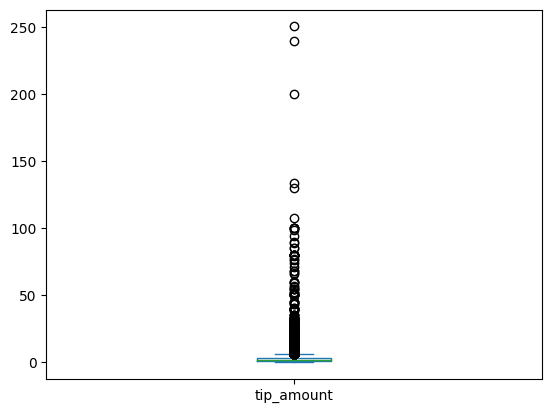

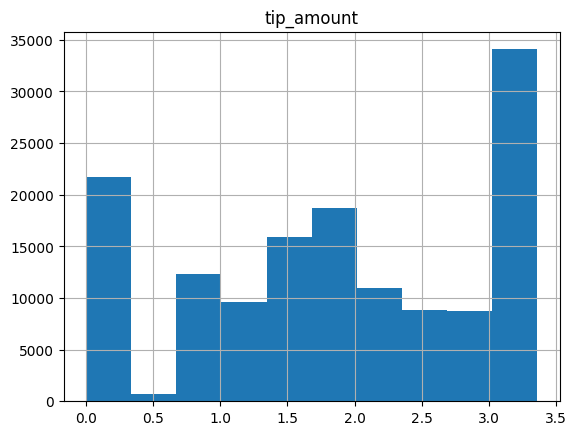

In [ ]:
y_train.plot(kind='box')
plt.savefig('../_static/example_green_taxi_tip_amount_boxplot.svg', format='svg')
plt.show()

y_train.clip(lower=0, upper=y_train.quantile(0.8)).to_frame().hist()
plt.savefig('../_static/example_green_taxi_tip_amount_distribution.svg', format='svg')
plt.show()

In [ ]:
# Fit the model
model = LGBMRegressor(random_state=111)
model.fit(X_train, y_train)

# Make predictions
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

In [ ]:
# Make baseline predictions
y_pred_train_baseline = np.ones_like(y_train) * y_train.mean()
y_pred_test_baseline = np.ones_like(y_test) * y_train.mean()

# Measure train, test and baseline performance
mae_train = mean_absolute_error(y_train, y_pred_train).round(4)
mae_test = mean_absolute_error(y_test, y_pred_test).round(4)

mae_train_baseline = mean_absolute_error(y_train, y_pred_train_baseline).round(4)
mae_test_baseline = mean_absolute_error(y_test, y_pred_test_baseline).round(4)

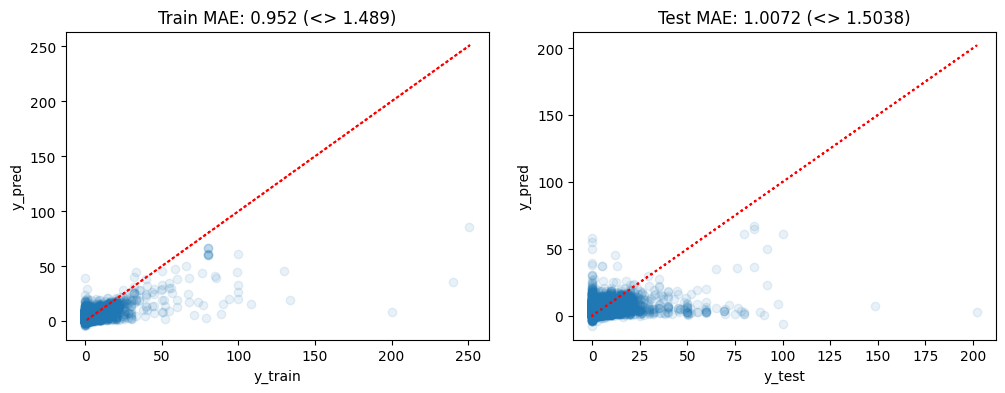

In [ ]:
# Create performance report
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,4))

title1 = 'Train MAE: {} (<> {})'.format(mae_train, mae_train_baseline)
ax1.set(title=title1, xlabel='y_train', ylabel='y_pred')
ax1.plot(y_train, y_train, color='red', linestyle=':')
ax1.scatter(y_train, y_pred_train, alpha=0.1)

title2 = 'Test MAE: {} (<> {})'.format(mae_test, mae_test_baseline)
ax2.set(title=title2, xlabel='y_test', ylabel='y_pred')
ax2.plot(y_test, y_test, color='red', linestyle=':')
ax2.scatter(y_test, y_pred_test, alpha=0.1)

plt.show()


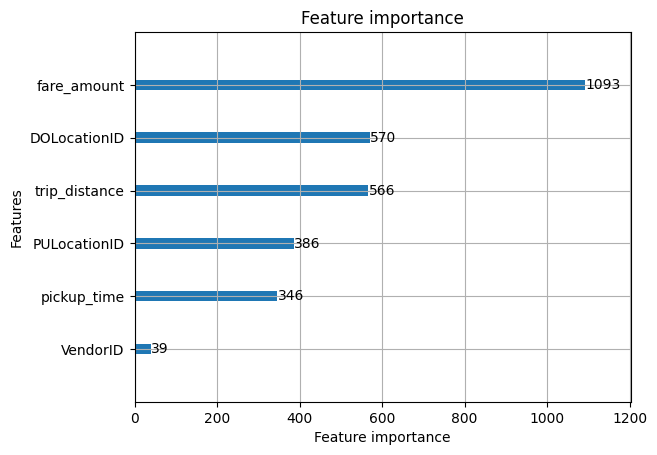

In [ ]:
# plot the feature importance
fig, ax = plt.subplots()
plot_importance(model, ax=ax)
plt.savefig('../_static/example_green_taxi_feature_importance.svg', format='svg')
plt.show()

In [ ]:
y_pred_prod = model.predict(X_prod)

In [ ]:
reference_df = X_test.copy() # using the test set as a reference
reference_df['y_pred'] = y_pred_test # reference predictions
reference_df['tip_amount'] = y_test # ground truth (currect targets)
reference_df = reference_df.join(data['lpep_pickup_datetime']) # date

analysis_df = X_prod.copy() # features
analysis_df['y_pred'] = y_pred_prod # prod predictions
analysis_df = analysis_df.join(data['lpep_pickup_datetime']) # date

In [ ]:
dle = nml.DLE(
    metrics=['mae'],
    y_true='tip_amount',
    y_pred='y_pred',
    feature_column_names=features,
    timestamp_column_name='lpep_pickup_datetime',
    chunk_period='d' # perform an estimation daily
)

dle.fit(reference_df) # fit on the reference (test) data
estimated_performance = dle.estimate(analysis_df) # estimate on the prod data

/var/home/nikml/.cache/pypoetry/virtualenvs/nannyml-Os0Ylq-N-py3.11/lib/python3.11/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


In [ ]:
figure = estimated_performance.plot()
figure.write_image(f'../_static/example_green_taxi_dle.svg')

In [ ]:
drdc = nml.DataReconstructionDriftCalculator(
    column_names=features,
    timestamp_column_name='lpep_pickup_datetime',
    chunk_period='d',
)

drdc.fit(reference_df)
multivariate_data_drift = drdc.calculate(analysis_df)

In [ ]:
figure = multivariate_data_drift.plot()
figure.write_image(f'../_static/example_green_taxi_pca_error.svg')

In [ ]:
udc = nml.UnivariateDriftCalculator(
    column_names=features,
    timestamp_column_name='lpep_pickup_datetime',
    chunk_period='d',
)

udc.fit(reference_df)
univariate_data_drift = udc.calculate(analysis_df)

In [ ]:
figure = univariate_data_drift.filter(period='all', metrics='jensen_shannon', column_names=['DOLocationID']).plot(kind='distribution')
figure.write_image(f'../_static/example_green_taxi_location_udc.svg')

In [ ]:
figure = univariate_data_drift.filter(period='all', metrics='jensen_shannon', column_names=['pickup_time']).plot(kind='distribution')
figure.write_image(f'../_static/example_green_taxi_pickup_udc.svg')

In [ ]:
figure = univariate_data_drift.filter(period='all', metrics='jensen_shannon').plot(kind='distribution')

figure.write_image(f'../_static/example_green_taxi_all_udc.svg')


In [ ]:
perfc = nml.PerformanceCalculator(
    metrics=['mae'],
    y_true='tip_amount',
    y_pred='y_pred',
    problem_type='regression',
    timestamp_column_name='lpep_pickup_datetime',
    chunk_period='d'
)

perfc.fit(reference_df)
realized_performance = perfc.calculate(analysis_df.assign(tip_amount = y_prod))

figure = estimated_performance.filter(period='analysis').compare(realized_performance).plot()
figure.write_image(f'../_static/example_green_taxi_dle_vs_realized.svg')